# Chapter 5 - Classification Techniques

### Ordinary Least Squares as a Classifier

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# load data
df = pd.read_csv('linear_classifier.csv')
df.head()

,x,y,labels
0,1,13,x
1,8,18,o
2,9,25,x
3,5,25,x
4,4,17,x


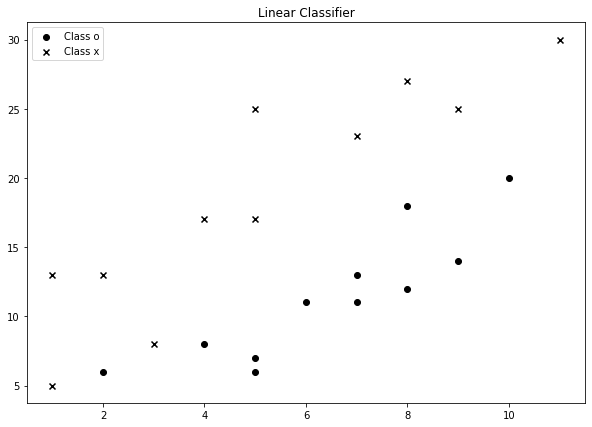

In [3]:
# plot data
plt.figure(figsize=(10,7))
for label, label_class in df.groupby('labels'):
    plt.scatter(label_class.values[:, 0],
                label_class.values[:, 1],
                label=f'Class {label}',
                marker=label,
                c='k')
plt.legend()
plt.title('Linear Classifier')
plt.show()

In [4]:
# Let's split the data in train and test to evaluate the model
df_train, df_test = train_test_split(df.copy(), test_size=0.4, random_state=12)

In [5]:
# Creating the linear model
model = LinearRegression()
model.fit(df_train.x.values.reshape(-1,1), df_train.y.values.reshape(-1,1))

LinearRegression()

In [6]:
print(f'y = {model.coef_[0][0]}x + {model.intercept_[0]}')

y = 1.2718120805369129x + 8.865771812080537


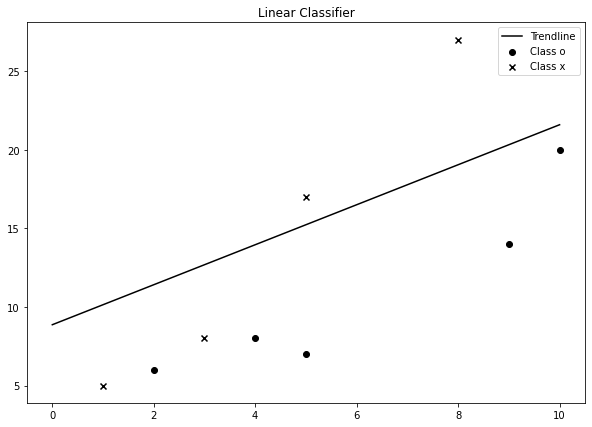

In [7]:
# Plot the fitted trendline over the test dataset
trend = model.predict(np.linspace(0,10).reshape(-1,1))

plt.figure(figsize=(10,7))
for label, label_class in df_test.groupby('labels'):
    plt.scatter(label_class.values[:,0], label_class.values[:,1],
                label=f'Class {label}', marker=label, c='k')
plt.plot(np.linspace(0, 10), trend, c='k', label='Trendline')
plt.legend()
plt.title("Linear Classifier")
plt.show()

In [8]:
# make predictions
y_pred = model.predict(df_test.x.values.reshape(-1,1))
pred_labels = []
for _y, _y_pred in zip(df_test.y, y_pred):
    if _y < _y_pred:
        pred_labels.append('o')
    else:
        pred_labels.append('x')
df_test['Pred labels'] = pred_labels
df_test.head()

,x,y,labels,Pred labels
7,4,8,o,o
10,5,17,x,x
21,3,8,x,o
15,1,5,x,o
14,9,14,o,o


Plot the points with the corresponding ground truth labels. For those points where the labels were correctly predicted, plot the corresponding class. For those incorrect predictions, plot a diamond

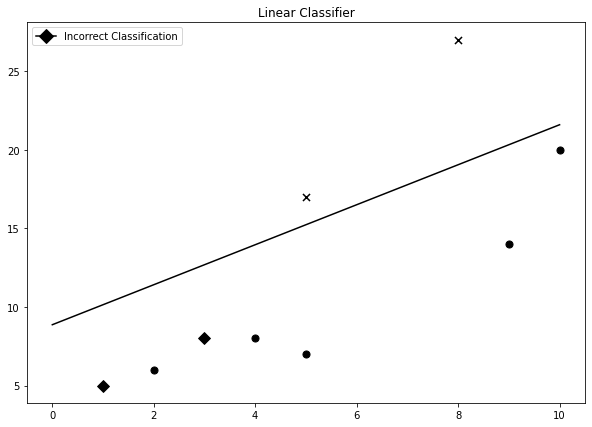

In [9]:
plt.figure(figsize=(10, 7))
for idx, label_class in df_test.iterrows():
    if label_class.labels != label_class['Pred labels']:
        label = 'D'
        s=70
    else:
        label = label_class.labels
        s=50
    plt.scatter(label_class.values[0], label_class.values[1],
                label=f'Class {label}', marker=label, c='k', s=s)
plt.plot(np.linspace(0, 10), trend, c='k', label='Trendline')
plt.title("Linear Classifier");
incorrect_class = mlines.Line2D([], [], color='k', marker='D',
                          markersize=10, label='Incorrect Classification');
plt.legend(handles=[incorrect_class])
plt.show()

# Logistic Regression

We will be using a sample of the famous MNIST dataset or on GitHub, which is a sequence of images of handwritten code digits, 0 through 0, with corresponding labels <br>

The MNIST dataset is comprised of 60,000 training samples and 10,000 test samples, where each sample is a grayscale image with a size of 28 x 28 pixels. In this exercise, we will use logistic regression to build a classifier. <br>

The first classifier we will build is a binary classifier, where we will determine whether the image is a handwritten 0 or a 1

In [10]:
# import packages
import numpy as np
import struct
import gzip
import urllib.request
import matplotlib.pyplot as plt
from array import array
from sklearn.linear_model import LogisticRegression
import warnings

In [11]:
# downloading data
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
with open('train-images-idx3-ubyte.gz', 'wb') as f:
    f.write(request.read())
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
with open('t10k-images-idx3-ubyte.gz', 'wb') as f:
    f.write(request.read())

In [12]:
# Downloading the corresponding labels for the data
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
with open('train-labels-idx1-ubyte.gz', 'wb') as f:
    f.write(request.read())
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
with open('t10k-labels-idx1-ubyte.gz', 'wb') as f:
    f.write(request.read())

In [13]:
# unzip the files in the local directory
!dir *.gz #for windows # !ls *.gz for linux and Mac

 O volume na unidade F ‚ Hevans
 O N£mero de S‚rie do Volume ‚ F8C8-B844

 Pasta de F:\Data_Science\Packt\SupervisedLearning

29/01/2021  23:05         1.648.877 t10k-images-idx3-ubyte.gz
29/01/2021  23:05             4.542 t10k-labels-idx1-ubyte.gz
29/01/2021  23:05         9.912.422 train-images-idx3-ubyte.gz
29/01/2021  23:05            28.881 train-labels-idx1-ubyte.gz

 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning

29/01/2021  23:05         1.648.877 t10k-images-idx3-ubyte.gz
29/01/2021  23:05             4.542 t10k-labels-idx1-ubyte.gz
29/01/2021  23:05         9.912.422 train-images-idx3-ubyte.gz
29/01/2021  23:05            28.881 train-labels-idx1-ubyte.gz

 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 P

In [14]:
# Load the downloaded data
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
    img = np.array(array("B", f.read())).reshape((size, rows, cols))
with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    labels = np.array(array("B", f.read()))
with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
    img_test = np.array(array("B", f.read())).reshape((size, rows, cols))
with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    labels_test = np.array(array("B", f.read()))

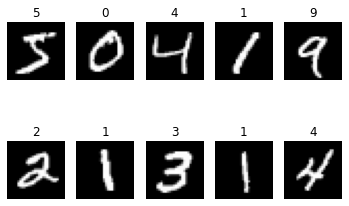

In [15]:
# plot of the first 10 images in the training sample
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i], cmap='gray')
    plt.title(f'{labels[i]}')
    plt.axis('off')

In [16]:
# selecting zeros and ones from the sample dataset
samples_0_1 = np.where((labels == 0) | (labels == 1))[0]
images_0_1 = img[samples_0_1]
labels_0_1 = labels[samples_0_1]
samples_0_1_test = np.where((labels_test == 0) | (labels_test == 1))
images_0_1_test = img_test[samples_0_1_test].reshape((-1, rows * cols))
labels_0_1_test = labels_test[samples_0_1_test]

Visualize one sample from the 0 selection and another from the handwritten 1 digits to ensure that we have correctly allocated the data.

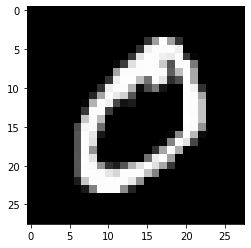

In [17]:
sample_0 = np.where((labels == 0))[0][0]
plt.imshow(img[sample_0], cmap='gray')
plt.show()

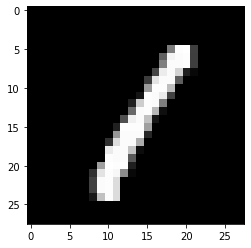

In [18]:
sample_1 = np.where((labels == 1))[0][0]
plt.imshow(img[sample_1], cmap='gray')
plt.show()

In [19]:
# reshaping data from matrix to vector form
images_0_1 = images_0_1.reshape((-1, rows * cols))
images_0_1.shape

(12665, 784)

In [20]:
# create the model
model = LogisticRegression(solver='liblinear') # especifying solver to avoid warning message
model.fit(X=images_0_1, y=labels_0_1)

LogisticRegression(solver='liblinear')

In [21]:
# Check the performance of this model
model.score(X=images_0_1, y=labels_0_1)

1.0

In this example, the model was able to predict the training labels with 100% accuracy.

In [22]:
# Look at some of the probabilities produced by the model for the training set
model.predict_proba(images_0_1)[:2]

array([[9.99999999e-01, 9.89532861e-10],
       [4.56461380e-09, 9.99999995e-01]])

For each prediction made, there are two probability values. The first for digit 0, and the second for digit 1

In [23]:
# Compute the performance of the model against the test set
model.score(X=images_0_1_test, y=labels_0_1_test)

0.9995271867612293

# Logistic Regression Multiclass Classifier

Given that the training data is so large, we will select a subset of the overall data to reduce the training time as well as the system resources required for the training process

In [24]:
np.random.seed(0)
selection = np.random.choice(len(img), 5000)
selected_images = img[selection]
selected_labels = labels[selection]

In [25]:
# reshape the input data in vector form
selected_images = selected_images.reshape((-1, rows * cols))
selected_images.shape

(5000, 784)

In [26]:
# preprocessing the data
selected_images = selected_images / 255
img_test = img_test / 255

This cell simply scales all the image values to between 0 and 1. Grayscale images are comprised of pixels with values between and including 0–255, where 0 is black and 255 is white.

In [27]:
# create the model
model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500, tol=0.1)
model.fit(X=selected_images, y=selected_labels)

LogisticRegression(max_iter=500, multi_class='multinomial', tol=0.1)

In [28]:
# calculate the model's accuracy in the train set
model.score(X=selected_images, y=selected_labels)

0.986

In [29]:
# making two predictions
model.predict(selected_images)[:2]

array([4, 1], dtype=uint8)

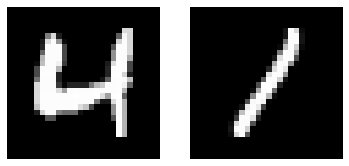

In [30]:
# seeing if the predictions are right
plt.subplot(1, 2, 1)
plt.imshow(selected_images[0].reshape((28, 28)), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(selected_images[1].reshape((28, 28)), cmap='gray')
plt.axis('off')
plt.show()

In [31]:
# print out the probability scores provided by the model for the first sample of the training set
model.predict_proba(selected_images)[0]

array([9.85332421e-07, 2.08479712e-14, 2.89818982e-05, 3.08253653e-11,
       9.99941522e-01, 1.09476058e-08, 1.57346550e-05, 7.40743121e-08,
       1.10471601e-05, 1.64398116e-06])

Notice that the fifth (index four) sample is the highest probability, thereby indicating a prediction of 4.

In [32]:
# calculate the model's accuracy in the test set
model.score(X=img_test.reshape((-1, rows * cols)), y=labels_test)

0.9002

# Select K Best Features

In [33]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

In [34]:
# load data
df = pd.read_csv('breast-cancer-data.csv')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [35]:
# separating the data in input and output
X, y = df[[c for c in df.columns if c != 'diagnosis']], df.diagnosis

In [36]:
# using SelectKBest to feature engeneering
# restricting to 2 best features so that we can visualize them on a plot
skb_model = SelectKBest(k=2)
X_new = skb_model.fit_transform(X, y)

In [37]:
# get the k best column names
mask = skb_model.get_support()
selected_features = []
for boolean, feature in zip(mask, df.columns):
    if boolean:
        selected_features.append(feature)
print(selected_features)

['worst perimeter', 'worst concave points']


Let's visualize how these two most important features correlate with the target (diagnosis) and how well they separate the two classes of diagnosis:

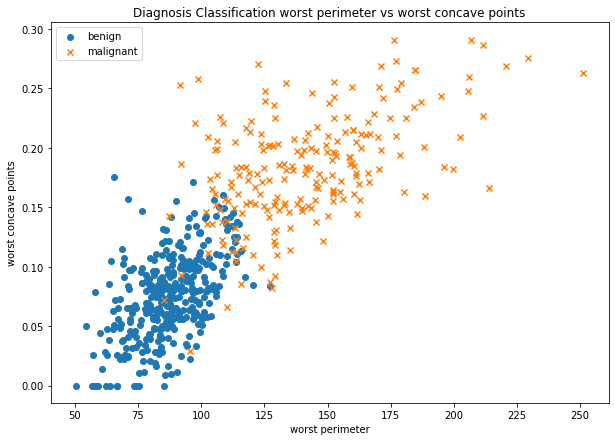

In [38]:
markers = {
    'benign': {'marker': 'o'},
    'malignant': {'marker': 'x'},
}
plt.figure(figsize=(10, 7))
for name, group in df.groupby('diagnosis'):
    plt.scatter(group[selected_features[0]], group[selected_features[1]], 
                label=name,
                marker=markers[name]['marker'],
               )
plt.title(f'Diagnosis Classification {selected_features[0]} vs {selected_features[1]}')
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.legend()
plt.show()

Before we can construct the model, we must first convert the diagnosis values into labels that can be used within the model. Replace the benign diagnosis string with the value 0, and the malignant diagnosis string with the value 1

In [39]:
diagnoses = [
    'benign', # 0
    'malignant', # 1
]
output = [diagnoses.index(diag) for diag in df.diagnosis]

In [40]:
# spliting the data in train and test
train_X, valid_X, train_y, valid_y = train_test_split(df[selected_features], output, test_size=0.2, random_state=123)

In [41]:
# create the model
model = LogisticRegression(solver='liblinear')
model.fit(df[selected_features], output)

LogisticRegression(solver='liblinear')

In [42]:
# calculate accuracy in the validation set
model.score(valid_X, valid_y)

0.9473684210526315

Construct another model using a random choice of selected_features and compare performance

In [43]:
selected_features = [
    'mean radius', # List features here
    'mean texture',
    'compactness error'
]
train_X, valid_X, train_y, valid_y = train_test_split(df[selected_features], output, 
                                                      test_size=0.2, random_state=123)
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)
model.score(valid_X, valid_y)

0.8859649122807017

Construct another model using all the available information and compare performance

In [44]:
selected_features = [
    feat for feat in df.columns if feat != 'diagnosis' # List features here
]
train_X, valid_X, train_y, valid_y = train_test_split(df[selected_features], output, test_size=0.2, random_state=123)
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)
model.score(valid_X, valid_y)

0.9824561403508771

# KNN Classification

In [45]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split

In [46]:
# load data
df = pd.read_csv('breast-cancer-data.csv')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


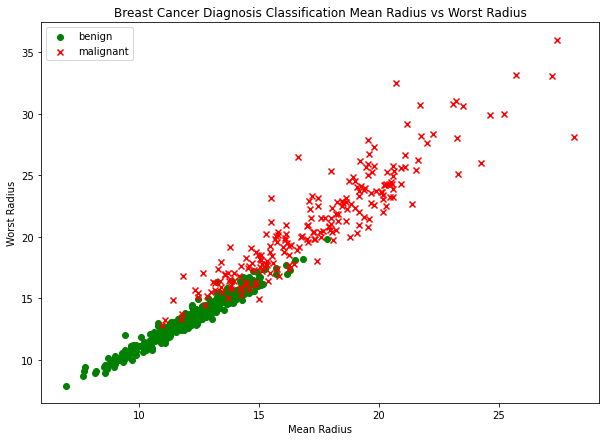

In [47]:
# Plotting a scatterplot for mean radius versus worst radius for each of the classes
# in the dataset with the corresponding diagnosis type
markers = {
    'benign': {'marker': 'o', 'facecolor': 'g', 'edgecolor': 'g'},
    'malignant': {'marker': 'x', 'facecolor': 'r', 'edgecolor': 'r'},
}

plt.figure(figsize=(10, 7))
for name, group in df.groupby('diagnosis'):
    plt.scatter(group['mean radius'], group['worst radius'], 
                label=name,
                marker=markers[name]['marker'],
                facecolors=markers[name]['facecolor'],
                edgecolor=markers[name]['edgecolor'])
    
plt.title('Breast Cancer Diagnosis Classification Mean Radius vs Worst Radius')
plt.xlabel('Mean Radius')
plt.ylabel('Worst Radius')
plt.legend()
plt.show()

In [48]:
# splitting the data in train data and validation data
train_X, valid_X, train_y, valid_y = train_test_split(df[['mean radius', 'worst radius']],
                                                      df.diagnosis,
                                                      test_size=0.2,
                                                      random_state=123)

# Construct a KNN classifier model with k = 3

In [49]:
model = KNN(n_neighbors=3)
model.fit(X=train_X, y=train_y)

KNeighborsClassifier(n_neighbors=3)

In [50]:
# calculate accuracy with the validation set
model.score(X=valid_X, y=valid_y)

0.9210526315789473

Create a list of the labels for later reference and iterate through this list, replacing the existing label with the corresponding index in the list

In [51]:
labelled_diagnoses = [
    'benign',
    'malignant',
]
for idx, label in enumerate(labelled_diagnoses):
    df.diagnosis = df.diagnosis.replace(label, idx)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [52]:
# Construct the model
model = KNN(n_neighbors = 3)
model.fit(X=df[['mean radius', 'worst radius']], y=df.diagnosis)

KNeighborsClassifier(n_neighbors=3)

To visualize our decision boundaries, we need to create a mesh or range of predictions across the information space, that is, all possible combinations of values of mean radius and worst radius. Starting with 1 unit less than the minimum for both the mean radius and worst radius, and finishing at 1 unit more than the maximum for mean radius and worst radius, use the arange function of NumPy to create a range of values between these limits in increments of 0.1 (spacing)

In [53]:
spacing = 0.1
mean_radius_range = np.arange(df['mean radius'].min() - 1, df['mean radius'].max() + 1, spacing)
worst_radius_range = np.arange(df['worst radius'].min() - 1, df['worst radius'].max() + 1, spacing)

In [54]:
# Use the NumPy meshgrid function to combine the two ranges in a grid
xx, yy = np.meshgrid(mean_radius_range, worst_radius_range)

In [55]:
# Concatenate the mesh into a single NumPy array using np.c_
pred_x = np.c_[xx.ravel(), yy.ravel()]
pred_x

array([[ 5.981,  6.93 ],
       [ 6.081,  6.93 ],
       [ 6.181,  6.93 ],
       ...,
       [28.881, 37.03 ],
       [28.981, 37.03 ],
       [29.081, 37.03 ]])

In [56]:
# Making predictions for the mesh
pred_y = model.predict(pred_x).reshape(xx.shape)
pred_y

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

To consistently visualize the boundaries, we will need two sets of consistent colors; a lighter set of colors for the decision boundaries, and a darker set of colors for the points of the training set themselves

In [57]:
# Create color maps
cmap_light = ListedColormap(['#6FF6A5', '#F6A56F'])
cmap_bold = ListedColormap(['#0EE664', '#E6640E',])

To highlight the decision boundaries, first plot the training data according to the diagnosis types, using the cmap_bold color scheme and different markers for each of the different diagnosis types

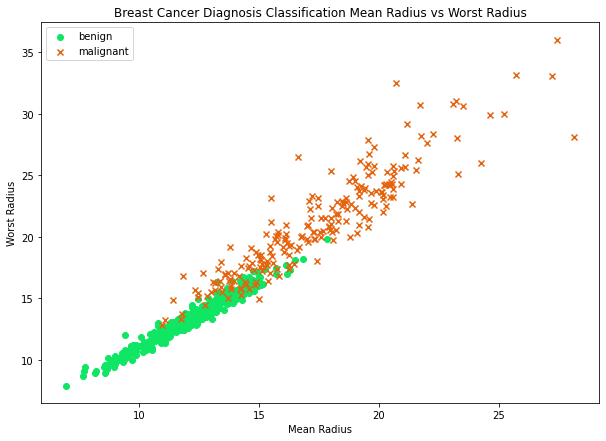

In [58]:
markers = {
    'benign': {'marker': 'o', 'facecolor': 'g', 'edgecolor': 'g'},
    'malignant': {'marker': 'x', 'facecolor': 'r', 'edgecolor': 'r'},
}

plt.figure(figsize=(10, 7))
for name, group in df.groupby('diagnosis'):
    diagnoses = labelled_diagnoses[name]
    plt.scatter(group['mean radius'], group['worst radius'],
                c=cmap_bold.colors[name],
                label=labelled_diagnoses[name],
                marker=markers[diagnoses]['marker']
               )
    
plt.title('Breast Cancer Diagnosis Classification Mean Radius vs Worst Radius')
plt.xlabel('Mean Radius')
plt.ylabel('Worst Radius')
plt.legend()
plt.show()

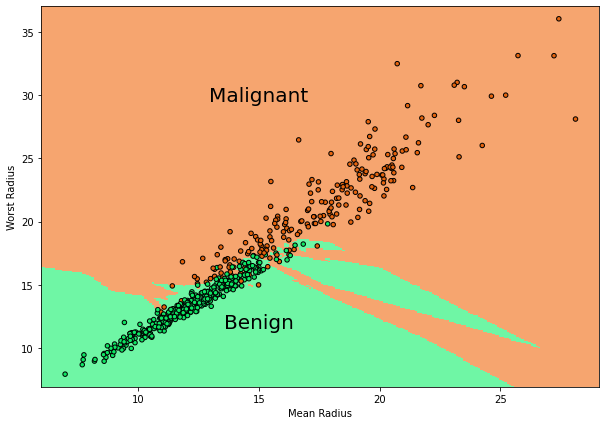

In [59]:
# ploting the decision boundaries
plt.figure(figsize=(10,7))
plt.pcolormesh(xx, yy, pred_y, cmap=cmap_light)
plt.scatter(df['mean radius'],
            df['worst radius'],
            c=df.diagnosis,
            cmap=cmap_bold,
            edgecolor='k',
            s=20
            )
plt.xlabel('Mean Radius')
plt.ylabel('Worst Radius')
plt.text(15, 12, 'Benign', ha='center',va='center', size=20,color='k')
plt.text(15, 30, 'Malignant', ha='center',va='center', size=20,color='k')
plt.show()

# Classification Using Decision Trees

## ID3 Classification

In [60]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# creating the dataframe
df = pd.DataFrame()
df['Outlook'] = [
    'sunny', 'sunny', 'overcast', 'rain', 'rain', 'rain',
    'overcast', 'sunny', 'sunny', 'rain', 'sunny',
    'overcast', 'overcast', 'rain'
]
df['Temperature'] = [
    'hot', 'hot', 'hot', 'mild', 'cool', 'cool', 'cool',
    'mild', 'cool', 'mild', 'mild', 'mild', 'hot', 'mild',
]
df['Humidity'] = [
    'high', 'high', 'high', 'high', 'normal', 'normal', 'normal', 
    'high', 'normal', 'normal', 'normal', 'high', 'normal', 'high'
]
df['Windy'] = [
    'Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak',
    'Strong', 'Strong', 'Weak', 'Strong'
]
df['Decision'] = ['N', 'N', 'P', 'P', 'P', 'N', 'P', 'N', 'P', 'P','P', 'P', 'P', 'N']
df

,Outlook,Temperature,Humidity,Windy,Decision
0,sunny,hot,high,Weak,N
1,sunny,hot,high,Strong,N
2,overcast,hot,high,Weak,P
3,rain,mild,high,Weak,P
4,rain,cool,normal,Weak,P
5,rain,cool,normal,Strong,N
6,overcast,cool,normal,Strong,P
7,sunny,mild,high,Weak,N
8,sunny,cool,normal,Weak,P
9,rain,mild,normal,Weak,P


In [62]:
# calculate the entropy for the Decision column
# Probability of P
p_p = len(df.loc[df.Decision == 'P']) / len(df)
# Probability of N
p_n = len(df.loc[df.Decision == 'N']) / len(df)

entropy_decision = -p_n * np.log2(p_n) - p_p * np.log2(p_p)

print(f'H(S) = {entropy_decision:0.4f}')

H(S) = 0.9403


In [63]:
# Creating a function to calculate entropy
def f_entropy_decision(data):
    p_p = len(df.loc[df.Decision == 'P']) / len(df)
    p_n = len(df.loc[df.Decision == 'N']) / len(df)
    return -p_n * np.log2(p_n) - p_p * np.log2(p_p)

In [64]:
# calculate which attribute provides the highest information gain
IG_decision_Outlook = entropy_decision # H(S)
# Create a string to print out the overall equation
overall_eqn = 'Gain(Decision, Outlook) = Entropy(Decision)' 
# Iterate through the values for outlook and compute the probabilities
# and entropy values
for name, Outlook in df.groupby('Outlook'):
    num_p = len(Outlook.loc[Outlook.Decision == 'P'])
    num_n = len(Outlook.loc[Outlook.Decision != 'P'])
    num_Outlook = len(Outlook)
    print(f'p(Decision=P|Outlook={name}) = {num_p}/{num_Outlook}')
    print(f'p(Decision=N|Outlook={name}) = {num_n}/{num_Outlook}')    
    print(f'p(Outlook={name}) = {num_Outlook}/{len(df)}')
    print(f'Entropy(Decision|Outlook={name}) = '\
         f'-{num_p}/{num_Outlook}.log2({num_p}/{num_Outlook}) - '\
         f'{num_n}/{num_Outlook}.log2({num_n}/{num_Outlook})')
    
    entropy_decision_outlook = 0
    
    # Cannot compute log of 0 so add checks
    if num_p != 0:
        entropy_decision_outlook -= (num_p / num_Outlook) \
            * np.log2(num_p / num_Outlook)
     
    # Cannot compute log of 0 so add checks
    if num_n != 0:
        entropy_decision_outlook -= (num_n / num_Outlook) \
            * np.log2(num_n / num_Outlook)
    
    IG_decision_Outlook -= (num_Outlook / len(df)) * entropy_decision_outlook
    print()
    overall_eqn += f' - p(Outlook={name}).'
    overall_eqn += f'Entropy(Decision|Outlook={name})'
print(overall_eqn)
print(f'Gain(Decision, Outlook) = {IG_decision_Outlook:0.4f}')

p(Decision=P|Outlook=overcast) = 4/4
p(Decision=N|Outlook=overcast) = 0/4
p(Outlook=overcast) = 4/14
Entropy(Decision|Outlook=overcast) = -4/4.log2(4/4) - 0/4.log2(0/4)

p(Decision=P|Outlook=rain) = 3/5
p(Decision=N|Outlook=rain) = 2/5
p(Outlook=rain) = 5/14
Entropy(Decision|Outlook=rain) = -3/5.log2(3/5) - 2/5.log2(2/5)

p(Decision=P|Outlook=sunny) = 2/5
p(Decision=N|Outlook=sunny) = 3/5
p(Outlook=sunny) = 5/14
Entropy(Decision|Outlook=sunny) = -2/5.log2(2/5) - 3/5.log2(3/5)

Gain(Decision, Outlook) = Entropy(Decision) - p(Outlook=overcast).Entropy(Decision|Outlook=overcast) - p(Outlook=rain).Entropy(Decision|Outlook=rain) - p(Outlook=sunny).Entropy(Decision|Outlook=sunny)
Gain(Decision, Outlook) = 0.2467


In [65]:
# We need to repeat this process quite a few times, so wrap it in a function 
def IG(data, column, ent_decision=entropy_decision):
    IG_decision = ent_decision
    for name, temp in data.groupby(column):
        p_p = len(temp.loc[temp.Decision == 'P']) / len(temp)
        p_n = len(temp.loc[temp.Decision != 'P']) / len(temp)
        entropy_decision = 0
        if p_p != 0:
            entropy_decision -= (p_p) * np.log2(p_p)
        if p_n != 0:
            entropy_decision -= (p_n) * np.log2(p_n)
        IG_decision -= (len(temp) / len(df)) * entropy_decision
    return IG_decision

In [66]:
# Repeat this process for each of the other columns
for col in df.columns[:-1]:
    print(f'Gain(Decision, {col}) = {IG(df, col):0.4f}')

Gain(Decision, Outlook) = 0.2467
Gain(Decision, Temperature) = 0.0292
Gain(Decision, Humidity) = 0.1518
Gain(Decision, Windy) = 0.0481


In [67]:
# This information provides the first decision of the tree
for name, temp in df.groupby('Outlook'):
    print('-' * 15)
    print(name)
    print('-' * 15)
    print(temp)
    print('-' * 15)

---------------
overcast
---------------
     Outlook Temperature Humidity   Windy Decision
2   overcast         hot     high    Weak        P
6   overcast        cool   normal  Strong        P
11  overcast        mild     high  Strong        P
12  overcast         hot   normal    Weak        P
---------------
---------------
rain
---------------
   Outlook Temperature Humidity   Windy Decision
3     rain        mild     high    Weak        P
4     rain        cool   normal    Weak        P
5     rain        cool   normal  Strong        N
9     rain        mild   normal    Weak        P
13    rain        mild     high  Strong        N
---------------
---------------
sunny
---------------
   Outlook Temperature Humidity   Windy Decision
0    sunny         hot     high    Weak        N
1    sunny         hot     high  Strong        N
7    sunny        mild     high    Weak        N
8    sunny        cool   normal    Weak        P
10   sunny        mild   normal  Strong        P
---------

In [68]:
# We now repeat this process, splitting by information gain until
# all the data is allocated and all branches of the tree terminate
df_next = df.loc[df.Outlook != 'overcast']
df_next

,Outlook,Temperature,Humidity,Windy,Decision
0,sunny,hot,high,Weak,N
1,sunny,hot,high,Strong,N
3,rain,mild,high,Weak,P
4,rain,cool,normal,Weak,P
5,rain,cool,normal,Strong,N
7,sunny,mild,high,Weak,N
8,sunny,cool,normal,Weak,P
9,rain,mild,normal,Weak,P
10,sunny,mild,normal,Strong,P
13,rain,mild,high,Strong,N


In [69]:
# Now, we will turn our attention to the sunny samples
df_sunny = df_next.loc[df_next.Outlook == 'sunny']

In [70]:
# Recompute the entropy for the sunny samples
entropy_decision = f_entropy_decision(df_sunny)
entropy_decision

0.9402859586706311

In [71]:
# Run the gain calculations for the sunny samples
for col in df_sunny.columns[1:-1]:
    print(f'Gain(Decision, {col}) = {IG(df_sunny, col, entropy_decision):0.4f}')

Gain(Decision, Temperature) = 0.7974
Gain(Decision, Humidity) = 0.9403
Gain(Decision, Windy) = 0.6007


In [72]:
# Again, we select the largest gain, which is Humidity
for name, temp in df_sunny.groupby('Humidity'):
    print('-' * 15)
    print(name)
    print('-' * 15)
    print(temp)
    print('-' * 15)

---------------
high
---------------
  Outlook Temperature Humidity   Windy Decision
0   sunny         hot     high    Weak        N
1   sunny         hot     high  Strong        N
7   sunny        mild     high    Weak        N
---------------
---------------
normal
---------------
   Outlook Temperature Humidity   Windy Decision
8    sunny        cool   normal    Weak        P
10   sunny        mild   normal  Strong        P
---------------


In [73]:
# Extract only the rain data and rerun the entropy calculation
df_rain = df_next.loc[df_next.Outlook == 'rain']
entropy_decision = f_entropy_decision(df_rain)
entropy_decision

0.9402859586706311

In [74]:
# Repeat the gain calculation with the rain subset
for col in df_rain.columns[1:-1]:
    print(f'Gain(Decision, {col}) = {IG(df_rain, col, entropy_decision):0.4f}')

Gain(Decision, Temperature) = 0.6007
Gain(Decision, Humidity) = 0.6007
Gain(Decision, Windy) = 0.9403


In [75]:
# Splitting on the attribute with the largest gain value requires splitting on the Windy values
for name, temp in df_rain.groupby('Windy'):
    print('-' * 15)
    print(name)
    print('-' * 15)
    print(temp)
    print('-' * 15)

---------------
Strong
---------------
   Outlook Temperature Humidity   Windy Decision
5     rain        cool   normal  Strong        N
13    rain        mild     high  Strong        N
---------------
---------------
Weak
---------------
  Outlook Temperature Humidity Windy Decision
3    rain        mild     high  Weak        P
4    rain        cool   normal  Weak        P
9    rain        mild   normal  Weak        P
---------------


# CART Decision Tree

In [76]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [77]:
# load data
df = pd.read_csv('breast-cancer-data.csv')
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [78]:
# Let's split the data in train and validation
train_X, valid_X, train_y, valid_y = train_test_split(df[set(df.columns)-{'diagnosis'}],
                                                     df.diagnosis,
                                                     test_size=0.3,
                                                     random_state=123)

In [79]:
# Create the model
model = DecisionTreeClassifier()
model = model.fit(train_X, train_y)

In [80]:
# Avaliate the model in the train set
model.score(train_X, train_y)

1.0

In [81]:
# Avaliate the model in the test set
model.score(valid_X, valid_y)

0.935672514619883

In [82]:
# import packages to visualize the tree
import graphviz
from sklearn.tree import export_graphviz

In [83]:
# plot the tree
dot_data = export_graphviz(model, out_file=None)
graph = graphviz.Source(dot_data)

# Neural Network Multiclass Classifier

In [84]:
# import packages
import numpy as np
import struct
import gzip
import urllib.request
import matplotlib.pyplot as plt
from array import array
from sklearn.neural_network import MLPClassifier
import warnings

In [85]:
# downloading data
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
with open('train-images-idx3-ubyte.gz', 'wb') as f:
    f.write(request.read())
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
with open('t10k-images-idx3-ubyte.gz', 'wb') as f:
    f.write(request.read())

In [86]:
# Downloading the corresponding labels for the data
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
with open('train-labels-idx1-ubyte.gz', 'wb') as f:
    f.write(request.read())
request = urllib.request.urlopen('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
with open('t10k-labels-idx1-ubyte.gz', 'wb') as f:
    f.write(request.read())

In [87]:
# unzip the files in the local directory
!dir *.gz #for windows # !ls *.gz for linux and Mac

 O volume na unidade F ‚ Hevans
 O N£mero de S‚rie do Volume ‚ F8C8-B844

 Pasta de F:\Data_Science\Packt\SupervisedLearning

29/01/2021  23:06         1.648.877 t10k-images-idx3-ubyte.gz
29/01/2021  23:06             4.542 t10k-labels-idx1-ubyte.gz
29/01/2021  23:06         9.912.422 train-images-idx3-ubyte.gz
29/01/2021  23:06            28.881 train-labels-idx1-ubyte.gz

 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning

29/01/2021  23:06         1.648.877 t10k-images-idx3-ubyte.gz
29/01/2021  23:06             4.542 t10k-labels-idx1-ubyte.gz
29/01/2021  23:06         9.912.422 train-images-idx3-ubyte.gz
29/01/2021  23:06            28.881 train-labels-idx1-ubyte.gz

 Pasta de F:\Data_Science\Packt\SupervisedLearning


 Pasta de F:\Data_Science\Packt\SupervisedLearning


 P

In [88]:
# Load the downloaded data
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
    img = np.array(array("B", f.read())).reshape((size, rows, cols))
with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    labels = np.array(array("B", f.read()))
with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as f:
    magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
    img_test = np.array(array("B", f.read())).reshape((size, rows, cols))
with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    labels_test = np.array(array("B", f.read()))

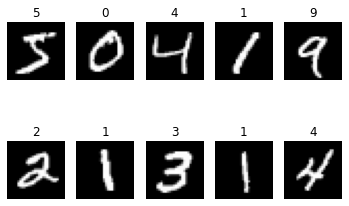

In [89]:
# plot of the first 10 images in the training sample
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i], cmap='gray')
    plt.title(f'{labels[i]}')
    plt.axis('off')

In [90]:
# select a subset of the overall data
np.random.seed(0) # Give consistent random numbers
selection = np.random.choice(len(img), 5000)
selected_images = img[selection]
selected_labels = labels[selection]

In [91]:
# reshape the input data in vector form
selected_images = selected_images.reshape((-1, rows * cols))
selected_images.shape

(5000, 784)

In [92]:
# normalizing data
selected_images = selected_images / 255
img_test = img_test / 255

In [93]:
# Construct the neural network model
model = MLPClassifier(solver='sgd', hidden_layer_sizes=(100,), max_iter=1000, random_state=1, learning_rate_init=0.01)
model.fit(X=selected_images, y=selected_labels)

MLPClassifier(learning_rate_init=0.01, max_iter=1000, random_state=1,
              solver='sgd')

In [94]:
# Calculate the accuracy against training set
model.score(X=selected_images, y=selected_labels)

1.0

In [95]:
# Determine the first two predictions for the training set
model.predict(selected_images)[:2]

array([4, 1], dtype=uint8)

In [96]:
# Calculate the accuracy against test set
model.score(X=img_test.reshape((-1, rows * cols)), y=labels_test)

0.9384